In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re, unicodedata
from keras.utils import to_categorical
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LeakyReLU, Conv1D,  GlobalMaxPooling1D
from keras.optimizers import Adam

In [ ]:
data_csv = pd.read_csv('/content/drive/MyDrive/Python_Training/Final_Project/combined_data.csv')
data_csv

,id,report,memc,bypass,csrf,dirtra,dos,execution,fileinc,gainpre,httprs,infor,overflow,sqli,xss
0,CVE-1999-0001,ip_input.c in BSD-derived TCP/IP implementatio...,0,0,0,0,1,0,0,0,0,0,0,0,0
1,CVE-1999-0002,Buffer overflow in NFS mountd gives root acces...,0,0,0,0,0,0,0,0,0,0,1,0,0
2,CVE-1999-0003,Execute commands as root via buffer overflow i...,0,0,0,0,0,0,0,0,0,0,1,0,0
3,CVE-1999-0004,"MIME buffer overflow in email clients, e.g. So...",0,0,0,0,0,0,0,0,0,0,1,0,0
4,CVE-1999-0005,Arbitrary command execution via IMAP buffer ov...,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115820,CVE-2021-43141,Cross Site Scripting (XSS) vulnerability exist...,0,0,0,0,0,0,0,0,0,0,0,0,1
115821,CVE-2021-43264,"In Mahara before 20.04.5, 20.10.3, 21.04.2, an...",0,1,0,1,0,0,0,0,0,0,0,0,0
115822,CVE-2021-43265,"In Mahara before 20.04.5, 20.10.3, 21.04.2, an...",0,0,0,0,0,0,0,0,0,0,0,0,1
115823,CVE-2021-43266,"In Mahara before 20.04.5, 20.10.3, 21.04.2, an...",0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
word_vector = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Python_Training/Final_Project/vulner_embedding.bin", binary=True)
# Access_Complexity_Level = ['LOW', 'MEDIUM', 'HIGH']
# Authentication_Level = ['NONE', 'SINGLE', 'MULTIPLE']
# Access_Vector_Level = ['LOCAL', 'NETWORK', 'ADJACENT_NETWORK']
# Confidentiality_Impact_Level = ['NONE', 'PARTIAL', 'COMPLETE']
# Availability_Impact_Level = ['NONE', 'PARTIAL', 'COMPLETE']
num_row = data_csv.shape[0]
name_labels = ['memcached', 'bypass', 'cross site request forgery', 'directory traversal', 'denial of service', 'execution', 'file inclusion', 'gain privilege',
          'http response splitting', 'information disclosure', 'overflow', 'sql injection', 'cross site scripting']
csv_labels = ['memc', 'bypass',	'csrf',	'dirtra',	'dos', 'execution',	'fileinc',	'gainpre',	'httprs',	'infor',	'overflow',	'sqli',	'xss']
data_csv[csv_labels] = data_csv[csv_labels].fillna(0.0)
combined_data_csv = data_csv.head(num_row)

##extract feautures

In [ ]:
def process_bar(idx, num):
    per = idx / num * 100
    if per % 5 == 0:
        print(f'Processing {int(per)}%')

In [ ]:
def process_report(report):
    report = report.lower()
    report = re.sub("<!--?.*?-->", "", report)
    report = unicodedata.normalize('NFKD', report).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    report= re.sub("(\\d|\\W)+"," ",report)
    report = re.sub('[^a-zA-z0-9\s]', "", report)
    sentences = [sentence for sentence in report.split() if sentence in word_vector]
    return sentences

In [ ]:
def feautures_extractor(report):
  sentences = process_report(report)
  vectors = [word_vector[sentence] for sentence in sentences]
  avg_vectors = np.mean(vectors, axis=0)
  return avg_vectors


def similar_counter(label, sentences):
  count = 0
  for sentence in sentences:
    similarity = word_vector.similarity(label, sentence)
    if similarity > 0.7:
      count += 1
  return count


def similarities_extractor(report):
  sentences = process_report(report)
  similar_vectors = []
  for label in name_labels:
    label_parts = [label_part for label_part in label.split()]
    counter = 0
    for label_part in label_parts:
      counter += similar_counter(label_part, sentences)
    similar_vectors.append(counter)
  return similar_vectors

In [ ]:
avg_vectors = []
similar_vectors = []
for idx in range(num_row):
    process_bar(idx, num_row)
    if idx == num_row-1:
      print(f'Processing 100%')
    avg_vector = feautures_extractor(data_csv['report'][idx])
    similar_vector = similarities_extractor(data_csv['report'][idx])
    avg_vectors.append(avg_vector)
    similar_vectors.append(similar_vector)

Processing 0%
Processing 20%
Processing 40%
Processing 60%
Processing 80%
Processing 100%


In [ ]:
features_df = pd.DataFrame(avg_vectors)
counters_df = pd.DataFrame(similar_vectors)
X = pd.concat([counters_df, features_df], axis=1)
X = X.astype(float)
y = combined_data_csv[csv_labels].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
28365,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.006432,0.207480,-0.088492,-0.124276,-0.054930,-0.053907,-0.112976,0.156283,0.294432,0.209858
19638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.070881,0.226761,0.042476,-0.129093,-0.037520,-0.165122,-0.214401,0.166374,0.160221,-0.013174
44703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.079810,0.170268,0.055702,-0.056446,-0.038653,-0.201915,-0.151402,0.191237,0.172401,-0.038669
112056,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.081117,0.270421,-0.054898,-0.160373,-0.029508,-0.014323,-0.188008,0.097122,0.186303,0.203609
32142,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.185412,0.199120,0.013854,-0.236795,-0.179263,-0.188185,-0.190366,0.027152,0.278521,0.205038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105319,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.129844,0.286082,0.004796,-0.122899,-0.015862,-0.108655,-0.161060,0.128383,0.281329,0.189363
11149,0.0,0.0,0.0,2.0,3.0,0.0,2.0,1.0,0.0,6.0,...,0.021266,0.185952,0.014262,-0.167351,0.066381,-0.082614,-0.157149,0.196905,0.361584,0.157532
73622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020373,0.239693,0.049553,-0.190930,-0.070154,-0.256550,-0.150497,0.132510,0.268204,0.120890
36060,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.156078,0.373067,-0.151769,-0.335551,0.001547,-0.112024,-0.184040,0.114362,0.129833,0.126213


##module & prediction

In [ ]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_train = y_train.apply(lambda x: x.argmax(), axis=1).values
label_test = y_test.apply(lambda x: x.argmax(), axis=1).values

gnb = GaussianNB().fit(X_train, label_train)
gnb_predictions = gnb.predict(X_test)

# accuracy on X_test
accuracy = gnb.score(X_test, label_test)
print(accuracy)

0.7470933578911017


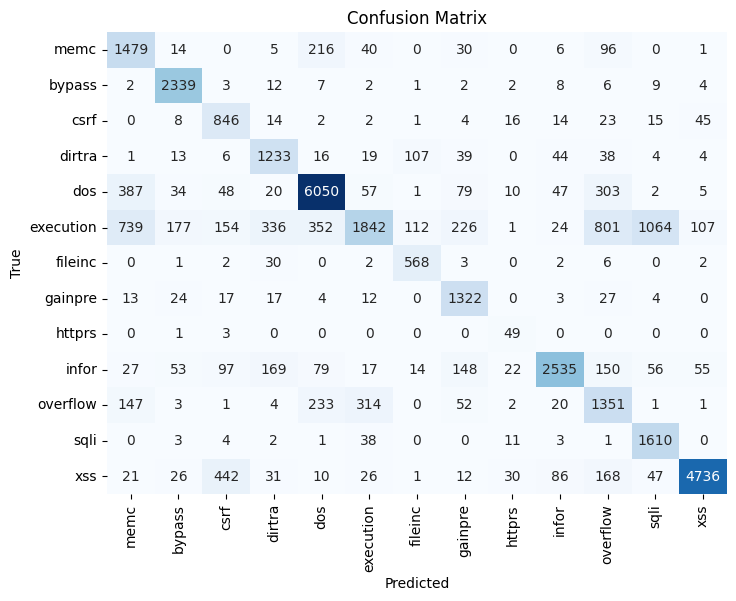

In [ ]:
# creating a confusion matrix
cm = confusion_matrix(label_test, gnb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=csv_labels, yticklabels=csv_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()